# Testing Frequency dependent model on Experimental data
The version of the model suffers from predicting multiple solutions on perfectly clean synthetic data.  
This data is not real and does not represent a physical material.  
This maybe what is causing the multiple solutions error. Testing on this silicon dataset will allow us to test the model on real data.


In [1]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import Model
from Model import FrequencyDependentModel
from Model.back_prop_utils import H_th_function, newton_raphson_fitting
from Model.plotting_utils import plot_transfer, plot_comparison, plot_training_progress, plot_material_params, compare_material_params
from Model.loss_functions import complex_real_imag_loss
sns.set_style("white")  

## Load experimental data

In [2]:
## Move file directory to import Extractor for signal manipulation
# Save the original sys.path
original_sys_path = sys.path.copy()

try:
    # Move two levels up to THz-TDS and add it to sys.path
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

    # Now import Extractor
    from Extraction.Extractor import Extractor

finally:
    # Restore sys.path to its original state
    sys.path = original_sys_path

In [3]:
# Define file paths within THz-TDS repo
ref_path = "data/ref.pulse.csv"
sample_path = "data/Si.pulse.csv"

# Load data 
ref = pd.read_csv(ref_path).to_numpy()
sample = pd.read_csv(sample_path).to_numpy()

In [4]:
print("Reference shape:", ref.shape)
print("Sample shape:", sample.shape)

Reference shape: (701, 2)
Sample shape: (701, 2)


In [5]:
extractor = Extractor(ref, sample, thickness=3*1e-3)

Reference:
Phase offset fit frequency range:  [1.00038735 4.00154938]
Phase slope:  -37.46477718688622
Mean squared error:  0.0671512209065479
(Should be ~< 1.)
--------------------
Sample:
Phase offset fit frequency range:  [1.00038735 4.00154938]
Phase slope:  -192.24418598426507
Mean squared error:  0.06413903301303736
(Should be ~< 1.)
--------------------
Transfer function:
Phase offset fit frequency range:  [1.00038735 4.00154938]
Phase slope:  -154.77940879737844
Mean squared error:  6.112181585650803e-05
(Should be ~< 1.)
--------------------


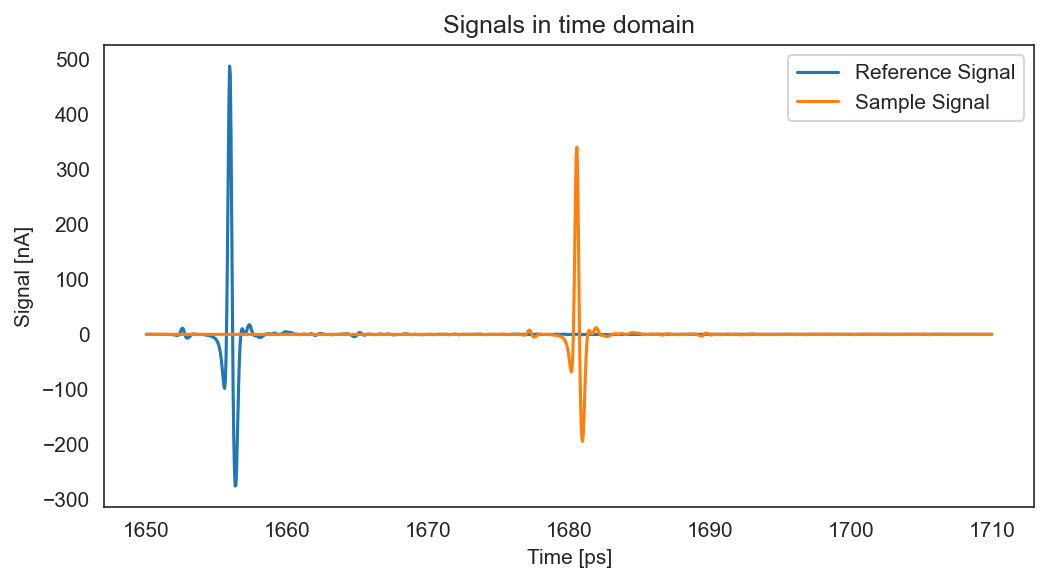

In [6]:
extractor.plot_time_domain()

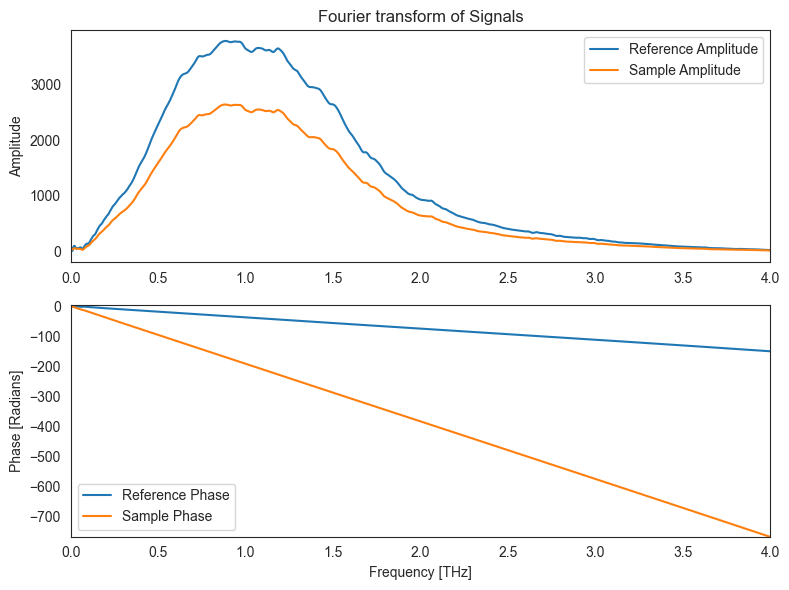

In [7]:
extractor.plot_frequency_domain(x_lims=[0,4])

In [8]:
df = extractor.get_fft_data()
df

,interpolated frequency,amplitude_signal_ref,amplitude_signal_sample,phase_signal_ref,phase_signal_sample,amplitude_transfer,phase_transfer,fast_n
0,0.000000,95.148531,15.572690,-0.429684,2.716322,0.163667,-3.137179,9.405027e+24
1,0.004880,69.694027,23.909452,-1.262713,0.623413,0.343063,-4.397059,1.533071e+01
2,0.009760,6.948951,37.244900,-1.993110,-0.880350,5.359788,-5.170426,9.425614e+00
3,0.014640,60.338845,47.704227,0.215530,-2.192593,0.790606,-2.408124,3.616151e+00
4,0.019520,98.849323,53.157152,-0.549669,-3.419308,0.537759,-2.869639,3.338151e+00
...,...,...,...,...,...,...,...,...
4091,19.963827,94.167196,53.476666,-2179.898373,-5123.353733,0.567891,-2956.021730,3.354959e+00
4092,19.968707,98.849323,53.157152,-2180.575001,-5124.510444,0.537759,-2956.501814,3.354766e+00
4093,19.973587,60.338845,47.704227,-2181.340200,-5125.737159,0.790606,-2956.963329,3.354558e+00
4094,19.978467,6.948951,37.244900,-2179.131560,-5127.049402,5.359788,-2954.201027,3.351784e+00


## Setup data for optimization

In [9]:
# Define frequency range we are interested in.
freqs_range = [0.3, 2]

freqs_THz = df['interpolated frequency']

# Find the closest available values within the range
lower_bound = freqs_THz[freqs_THz >= freqs_range[0]].min()
upper_bound = freqs_THz[freqs_THz <= freqs_range[1]].max()

# Apply the boundaries
# Ensure df['frequency'] exists and corresponds to freqs_THz
df_filtered = df[(df['interpolated frequency'] >= lower_bound) & (df['interpolated frequency'] <= upper_bound)]
freqs_THz = freqs_THz[(freqs_THz >= lower_bound) & (freqs_THz <= upper_bound)]

H_values = df_filtered['amplitude_transfer']
phi_values = df_filtered['phase_transfer'] 

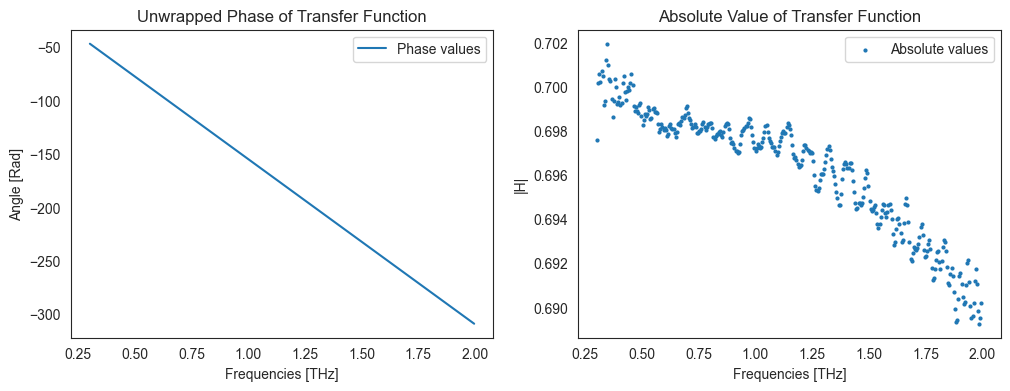

In [10]:
plot_transfer(freqs_THz, H_values, phi_values)

## Optimize n and k

Epoch 0: Loss = 1.0584514141082764 (Best Loss = 1.0584514141082764)
Epoch 25: Loss = 0.11583082377910614 (Best Loss = 0.11583082377910614)
Epoch 50: Loss = 0.022611625492572784 (Best Loss = 0.022611625492572784)
Epoch 75: Loss = 0.0014015651540830731 (Best Loss = 0.0014015651540830731)
Epoch 100: Loss = 6.256567576201633e-05 (Best Loss = 6.256567576201633e-05)
Epoch 125: Loss = 1.044542841555085e-05 (Best Loss = 9.629276974010281e-06)
Epoch 150: Loss = 3.460935715793312e-07 (Best Loss = 3.460935715793312e-07)
Epoch 175: Loss = 5.972002270482335e-08 (Best Loss = 5.756303522730377e-08)
Epoch 200: Loss = 2.740215609975394e-09 (Best Loss = 2.414698219155298e-09)
Epoch 225: Loss = 1.829979778822377e-10 (Best Loss = 1.829979778822377e-10)
Time taken: 0.057250583020504564 s


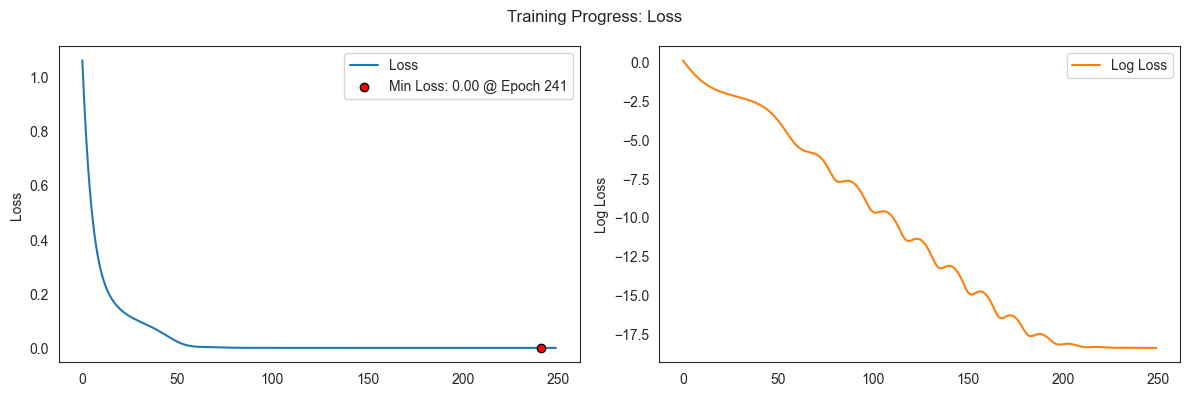

In [11]:
from time import perf_counter
thickness = 3*1e-3
freqs = freqs_THz * 2 * np.pi * 1e12
freqs = torch.tensor(freqs.to_numpy(), dtype=torch.float32)

H_abs_t = torch.tensor(H_values.to_numpy(), dtype=torch.float32)
H_phi_t = torch.tensor(phi_values.to_numpy(), dtype=torch.float32)

H_exp = H_abs_t * torch.exp(1j*H_phi_t)

model = FrequencyDependentModel(freqs, thickness, 3.44, 0.001)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

start = perf_counter()
model.train_model(H_exp=H_exp, Physical_model=H_th_function, loss_fn=complex_real_imag_loss, epochs=250, optimizer=optimizer, updates=25)
print(f'Time taken: {perf_counter() - start} s')

sns.set_style("white")  
plot_training_progress(model.loss_history)

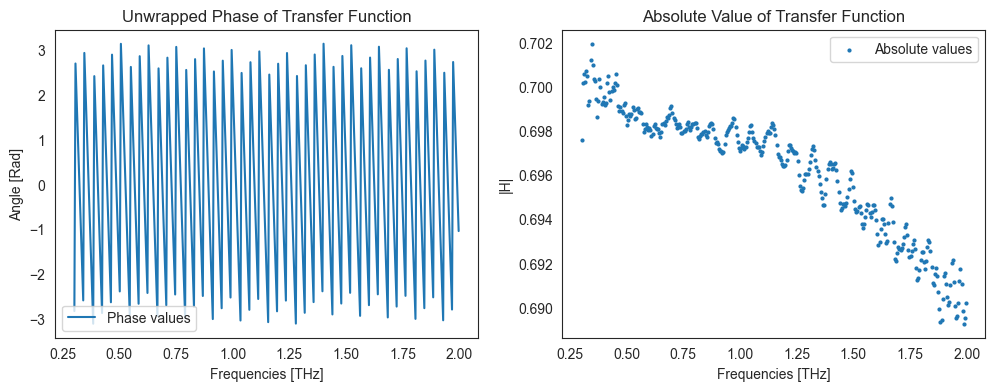

In [12]:
n_opt = model.best_n
k_opt = model.best_k

complex_opt = n_opt + 1j*k_opt
H_indep = H_th_function(n_complex=complex_opt, w=freqs, length=thickness)

plot_transfer(frequencies=freqs_THz, absolute_values=torch.abs(H_indep), phase_values=torch.angle(H_indep))

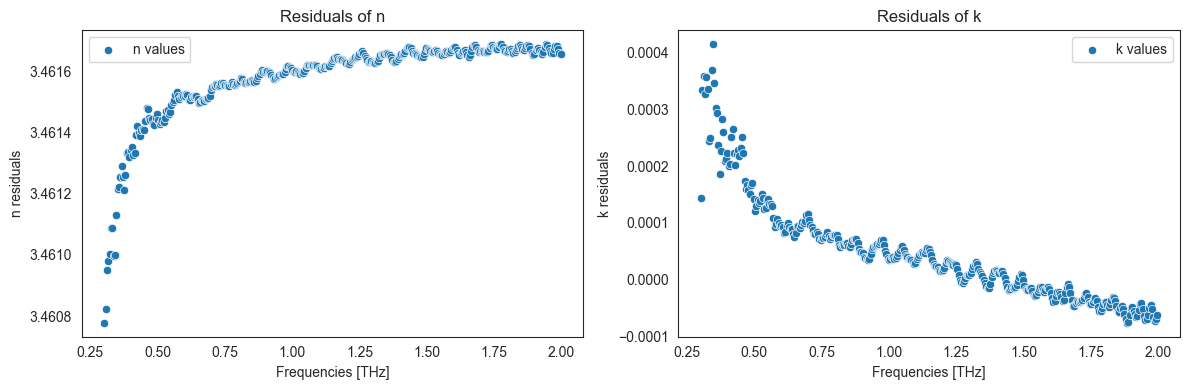

In [13]:
plot_material_params(freqs_THz, n_opt, k_opt)

## Analyze Solution

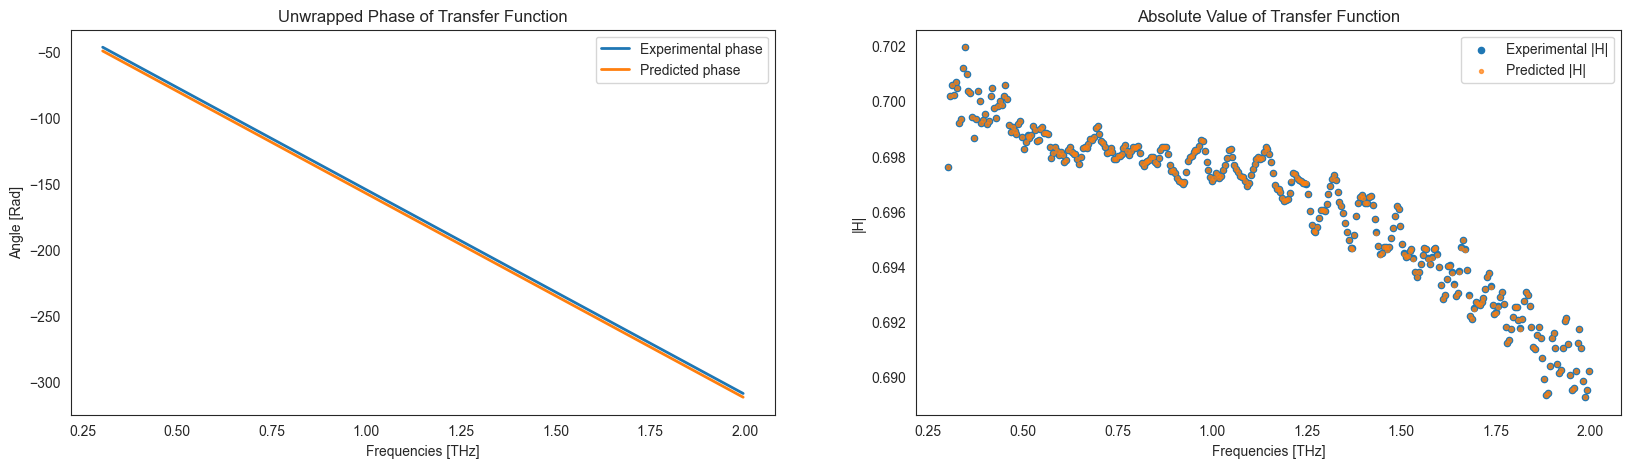

In [14]:
offset = max(phi_values)
phi_opt = np.unwrap(torch.angle(H_indep)) + offset
H_opt = torch.abs(H_indep)

plot_comparison(freqs_THz, H_values, phi_values, H_opt, phi_opt)

In [15]:
NR = pd.read_csv('data/NR-optimised_values.csv')
# Truncate frequencies 
NR = NR[NR['frequencies'] <= 2]

NR_freqs = torch.tensor(NR['frequencies'].to_numpy(),  dtype=torch.float32)
NR_freqs = NR_freqs * 1e12 * 2 * np.pi

# Ensure the column is a NumPy complex array
n_NR_np = np.array(NR['n_NR'], dtype=np.complex128)

# Convert to a PyTorch complex tensor
n_NR = torch.tensor(n_NR_np, dtype=torch.cfloat)

NR_H = H_th_function(n_NR, NR_freqs, thickness)

abs_NR_H = torch.abs(NR_H)
phi_NR = np.unwrap(np.angle(NR_H))

# Add transfer function values to dataframe
NR['abs_NR_H'] = abs_NR_H
NR['phi_NR'] = phi_NR
NR['n'] = torch.real(n_NR)
NR['k'] = torch.imag(n_NR)

NR_extended = NR

# Truncate NR for optimal plotting
NR = NR[NR['frequencies'] >= 0.3]

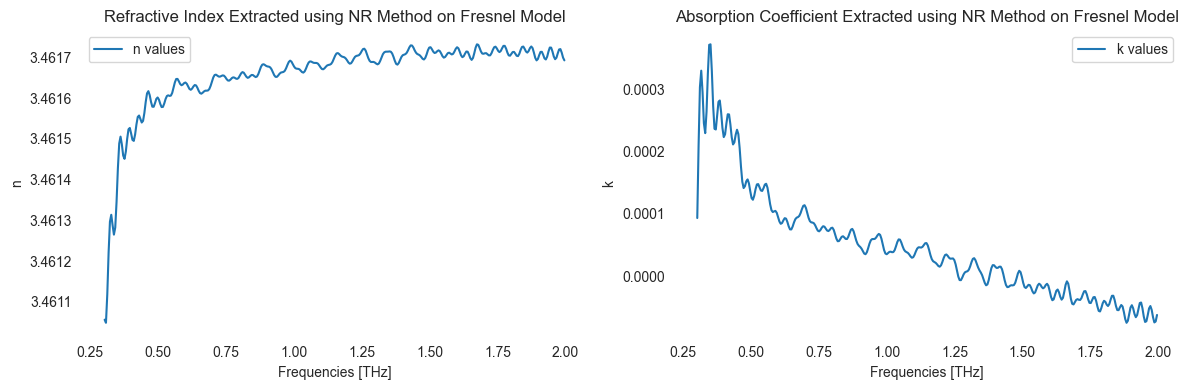

In [16]:
sns.set_style("white")  # Removes grid and background automatically


# Create the first subplot (assuming 'data1' is your first dataset)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
for ax in [ax1, ax2]:
    for spine in ax.spines.values():
        spine.set_visible(False)

# First plot: Approximate values of n from NR solution
sns.lineplot(x=NR['frequencies'], y=NR['n'], label="n values", ax=ax1)
ax1.set_title('Refractive Index Extracted using NR Method on Fresnel Model')
ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax1.set_xlabel('Frequencies [THz]')

# Second plot (assuming 'data2' is your second dataset with x and y values)
sns.lineplot(x=NR['frequencies'], y=NR['k'], label="k values", ax=ax2)
ax2.set_title('Absorption Coefficient Extracted using NR Method on Fresnel Model')
ax2.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax2.set_xlabel('Frequencies [THz]')

# Adjust layout and add main title if needed
plt.tight_layout()
plt.legend()
plt.show()

### Compare to NR solution 

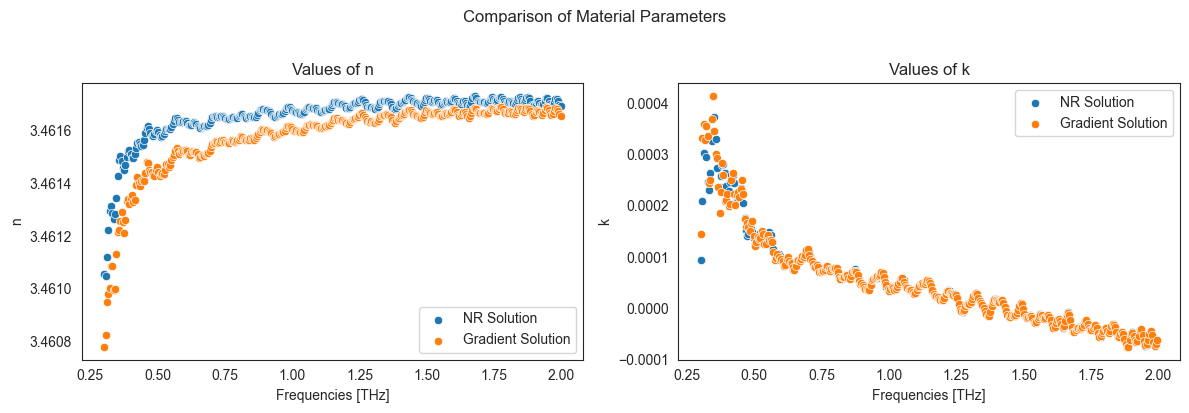

In [17]:
compare_material_params(freqs_THz, NR['n'], NR['k'], n_opt, k_opt)

### Plot residuals

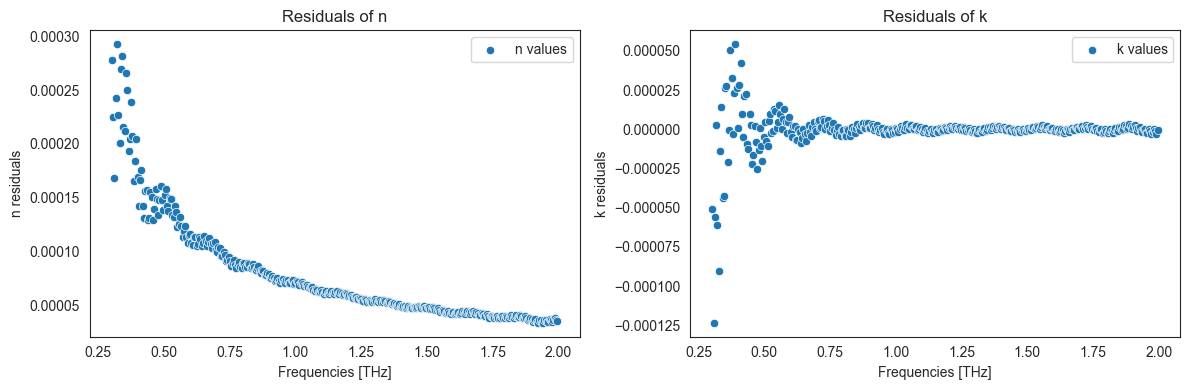

In [18]:
n_residuals = torch.tensor(NR['n'].to_numpy(), dtype=torch.float32) - n_opt
k_residuals = torch.tensor(NR['k'].to_numpy(), dtype=torch.float32) - k_opt

plot_material_params(freqs_THz, n_residuals, k_residuals)

### Compare Sequential, NR and Tensor approaches 

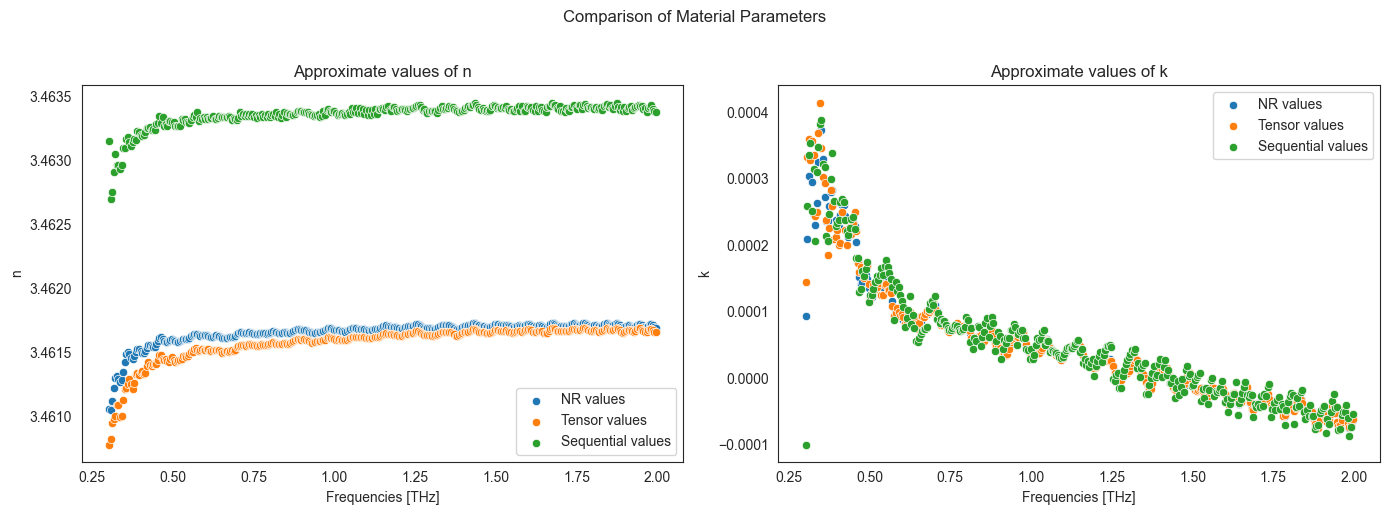

In [19]:
sequential_df = pd.read_csv('data/Sequential_extraction.csv')


# Create the first subplot (assuming 'data1' is your first dataset)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# First plot: Approximate values of n from NR solution
sns.scatterplot(x=freqs_THz, y=NR['n'], label="NR values", ax=ax1)
sns.scatterplot(x=freqs_THz, y=n_opt, label="Tensor values", ax=ax1)
sns.scatterplot(x=sequential_df['freqs'], y=sequential_df['n'], label="Sequential values", ax=ax1)
ax1.set_title('Approximate values of n')
ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax1.set_xlabel('Frequencies [THz]')


sns.scatterplot(x=freqs_THz, y=NR['k'], label="NR values", ax=ax2)
sns.scatterplot(x=freqs_THz, y=k_opt, label="Tensor values", ax=ax2)
sns.scatterplot(x=sequential_df['freqs'], y=sequential_df['k'], label="Sequential values", ax=ax2)
ax2.set_title('Approximate values of k')
ax2.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax2.set_xlabel('Frequencies [THz]')

# Adjust layout and add main title if needed
plt.suptitle('Comparison of Material Parameters', y=1.02)
plt.tight_layout()
plt.legend()
plt.show()